<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Main/In_order/Figure3_Complete_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the time
import math # needed for calculations
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque

class Opinon_w_media():
    def __init__(self, N=10**3, M=10, terminal_time=500,bM=5,b=25,noise_level=0.1,duration=50,nbins=10,h=0.01,r_scale=100):
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta=torch.distributions.beta.Beta(3,2)
        self.s=Beta.sample(sample_shape=(N,))
        self.ym= torch.linspace(-1,1,steps=self.M)  # Uniformly distributed between -1 and 1
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration=duration
        self.action_dim=4
        self.nbins=nbins
        self.h=h
        self.pi=torch.tensor(np.pi)
        self.r_scale=r_scale

    def reset(self):
        self.state = torch.cat([torch.rand(self.N) * 2 - 1, 1*torch.ones(self.M), torch.tensor([0.])])
        # self.s = torch.clamp(torch.normal(0.5, 0.3, size=(self.N,)), 0, 1)
        return self.state

    def action_encoder(self,number):
        num_bits = int(self.M/2)
        binary_string = format(number, f'0{num_bits}b')
        action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
        return action_vector

    def action_decoder(self,action_vector):
        binary_string = ''.join(str(int(bit)) for bit in action_vector)
        number = int(binary_string, 2)
        return number

    def dyn_step(self,u_action_id, v_action_id):
      done=False
      state=self.state
      reward=0
      h=self.h
      gam=.98
      u_action=env.action_encoder(u_action_id)
      v_action=env.action_encoder(v_action_id)
      for i in range(self.duration):
            x, c, t = state[:self.N], state[self.N:-1], state[-1]
            DM  = self.ym - x[:, None]
            D   =  x - x[:, None]
            action = torch.cat([u_action, v_action])
            eta=1
            eta2=2
            AM = torch.exp(-self.bM * (1+eta*(action))*(1+eta2*(1-c)*(1-self.s.reshape(-1, 1))) * torch.abs(DM))
            A = torch.exp(-self.b  * torch.abs(D))
            t   += 1
            c= c*(gam)+action*(1-gam)
            x +=h*((torch.sum(A * D  , dim=1) / torch.sum(A, dim=1))+ (torch.sum(AM * DM  , dim=1) / torch.sum(AM  , dim=1)))+ torch.sqrt(h)*torch.normal(0, self.noise_level, size=(self.N,))
            state = torch.cat([x, c, t.unsqueeze(0)])
      self.state = state
      reward=self.r_scale*(-1*(torch.sin(self.pi*x/2)).pow(5)).mean()
      if t >= self.terminal_time:
            done = True
      return  reward, done

    def state2obs(self,state):
        xs=state[:self.N].clone().detach()
        cs=state[self.N:self.N+self.M].clone().detach()
        return torch.cat([1*torch.histc(xs, bins=self.nbins, min=-1, max=1)/self.N, cs])
        # return torch.cat([xs, cs])

    def step(self, u_action_id, v_action_id):
        reward, done=self.dyn_step(u_action_id, v_action_id)
        return self.state, reward, done, None
    def complet_action_space(self):
        action_space = torch.zeros((2**int(self.M/2),int(M/2)))
        for i in range(2**int(self.M/2)):
            action_space[i,:]=self.action_encoder(i)
        return action_space



class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(* batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)


# def actoin_encoder(number, num_bits = M):
#     binary_string = format(number, f'0{num_bits}b')
#     action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
#     return action_vector

# def actoin_decoder(action_vector):
#     binary_string = ''.join(str(int(bit)) for bit in action_vector)
#     number = int(binary_string, 2)
#     return number

#################################-----------------------------------------------
class soft_q_net(nn.Module):
    def __init__(self, observation_dim,bpl,bop,M,action_dim=32):
        super(soft_q_net, self).__init__()
        self.observation_dim = observation_dim
        self.bpl = bpl
        self.bop = bop
        self.action_dim=action_dim
        self.M=M
        self.makspl=torch.zeros(action_dim,action_dim)
        self.maksop=torch.zeros(action_dim,action_dim)
        for i in range(action_dim):
            self.makspl[i,:]=i*action_dim+torch.arange(action_dim)
        for i in range(action_dim):
            self.maksop[i,:]=action_dim*torch.arange(action_dim)+i
                # Using The initialization & incorporating batch normalization
        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        # self.fc4 = nn.Linear(512, 2*self.action_dim**2)
        self.fc3 = nn.Linear(512, self.action_dim**2)
        # self.dropout = nn.Dropout(p=0.3)
        # self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.fill_(0.0)  # Set all weights to zero
                if m.bias is not None:
                    m.bias.data.fill_(0.0)  # Keep bias initialization as is, setting to zero


    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        # x = self.fc4(x)
        # x = F.relu(x)
        x = self.fc3(x)
        return x

    def log_sum_exp(self,x):
        max_x=x.max(dim=1,keepdim=True)[0]
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=-1)
        return torch.log(sum_of_exps) + max_x.squeeze()

    def getV(self, q_value):
        Q_pl=self.getQ_pl(q_value)
        v = (1/self.bpl) * (self.log_sum_exp(self.bpl * Q_pl)-torch.log(torch.tensor(self.action_dim)))
        return v


    # consider uniform policies
    def getQ_pl(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bop*q_value[:,self.makspl[i,:].int()]
            Qa[:,i]=(1/self.bop)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
        Q_pl=Qa
        return    Q_pl



    def getQ_op(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bpl*q_value[:,self.maksop[i,:].int()]
            Qa[:,i]=(1/self.bpl)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
            # Qa[:,i]=((self.bpl*q_value[:,self.maksop[i,:].int()].squeeze()).exp()).sum(dim=-1)/(self.action_dim)
        # Q_op = (1/self.bpl) * Qa.log()
        Q_op=Qa
        return    Q_op


    def act(self, observation):
        with torch.no_grad():
            # observation = torch.FloatTensor(np.expand_dims(obs, 0))
            q_value = self.forward(observation)
            Q_pl=self.getQ_pl(q_value)
            Q_op=self.getQ_op(q_value)
            pi_pl=F.softmax(self.bpl*Q_pl, dim=-1)
            pi_op=F.softmax(self.bop*Q_op, dim=-1)

            dist_pl = torch.distributions.Categorical(pi_pl)
            dist_op = torch.distributions.Categorical(pi_op)
            ac_pl=dist_pl.sample().item()
            ac_op=dist_op.sample().item()
            ac_id=ac_pl*self.action_dim+ac_op
        return ac_pl, ac_op,ac_id,torch.cat([pi_pl,pi_op])



def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU):
      observation, action, reward, next_observation, done = buffer.sample(batch_size)
      observation = torch.FloatTensor(observation)
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      next_observation = torch.FloatTensor(next_observation)
      done = torch.FloatTensor(done)

      q_values = eval_model.forward(observation)
      next_q_values = target_net.forward(next_observation)
      next_v_values = target_net.getV(next_q_values)
      expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      loss = (expected_q_value.detach() - q_value).pow(2)
      loss = loss.mean()
      optimizer.zero_grad()
      loss.backward()
      # if count % 1000 == 0:
      #   with torch.no_grad():
            # print(f'State diffrence Q: {q_values.var(dim=0).max():.1e},\t action diffrence Q: {q_values.var(dim=1).max():.1e}')
      # torch.nn.utils.clip_grad_norm_(eval_model.parameters(), max_norm=1)
      optimizer.step()
      # if count % (1*10**5) == 0:
      #     target_net.load_state_dict(eval_model.state_dict())
      #     print(100*'*','New Target Network',100*'*')
      # Soft update of the target network's weights
      # θ ← τ θ' + (1 −τ )θ′
      target_net_state_dict = target_model.state_dict()
      policy_net_state_dict = eval_model.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_model.load_state_dict(target_net_state_dict)
      with torch.no_grad():
        loss_p=((expected_q_value.detach() - q_value).pow(2).mean())
        loss_n=loss_p/q_value.var()
      return loss_p,loss_n,next_q_values



# Training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


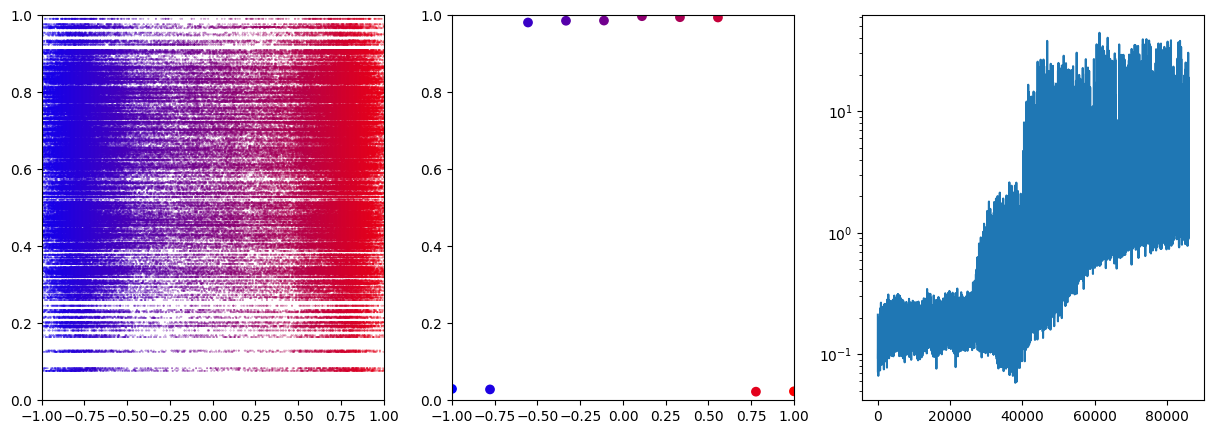

run:0,	 Epoch: 86000, 	 Loss: 8.2e-01,	 Normal Loss: 3.9e-02, 	 count : 4.3e+06, 	 Reward : -6.1e-02
[0.0296174  0.02820796 0.9812431  0.9857901  0.986259   0.99761677
 0.99497885 0.99427116 0.02235845 0.02327269]


KeyboardInterrupt: 

In [ ]:
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
# fig,ax=plt.subplots(1,2,figsize=(10,5))

C=[]
X=[]
for run in range(10):
  N = 500
  M=10
  terminal_time=200
  T_end=terminal_time
  Duration=1
  nbins=30
  scale=20
  env = Opinon_w_media(N=N, M=M, terminal_time = terminal_time,bM=5,b=20,noise_level=0.1,duration=Duration,h=torch.tensor(.1),nbins=nbins,r_scale=scale)
  env.reset()

  bins=np.linspace(-1,1,nbins)
  min_loss = 5*10**4
  gamma = 0.95
  learning_rate = 1e-4
  batch_size = 64
  update_freq = batch_size*1
  capacity = 1*10**5
  render = False
  episode = 2000000
  observation_dim = nbins+M
  bpl=10
  bop=-10
  TAU=0.01
  action_dimension=2**int(M/2)
  save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_res'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
  target_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
  eval_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
  avg_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
  eval_net.load_state_dict(target_net.state_dict())
  # optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-2)
  optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-3)
  buffer = replay_buffer(capacity)
  loss_fn = nn.MSELoss()
  count = 0
  reward_total = []
  Loss=[]
  R_t=0
  loss_p=-1
  epoch=0
  Loss=[]
  reward_total=[]
  for i in range(episode):
      xct=env.reset()
      obs = env.state2obs(xct)
      if epoch>(100000-1):
          break
      while True:
          u_action, v_action,action_id,action_dist = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
          count += 1
          n_xct, reward, Done, _  = env.step(u_action,v_action)
          x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
          next_obs = env.state2obs(n_xct)
          buffer.store(obs, action_id, reward, next_obs, Done)
          reward_total.append(reward)
          obs = next_obs
          if len(buffer.memory) > batch_size:
              if count % 50 == 0:
                  epoch+=1
                  loss_p,loss_n,q_print=train(buffer, target_net, eval_net, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU)
                  Loss.append(loss_p)
                  for key in eval_net.state_dict():
                        avg_net.state_dict()[key] = eval_net.state_dict()[key]/1000 + avg_net.state_dict()[key]
                  if epoch%2000==0:
                      fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                      # ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=1, cmap=cmap)
                      ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=.1, cmap=cmap,alpha=.5)
                      ax[0].set_ylim(0, 1)
                      ax[0].set_xlim(-1, 1)
                      ax[1].scatter(x=np.linspace(-1, 1, env.M), y=np.array(C).mean(axis=0), c=np.linspace(-1, 1, env.M), cmap=cmap)
                      ax[1].set_ylim(0, 1)
                      ax[1].set_xlim(-1, 1)
                      ax[2].semilogy(np.array(Loss))

                      clear_output(wait=True)  # Clear the output of the existing plot before redrawing
                      display(plt.gcf())  # Display the current figure
                      print(f'run:{run},\t Epoch: {epoch}, \t Loss: {np.array(Loss).mean():.1e},\t Normal Loss: {loss_n:.1e}, \t count : {count:.1e}, \t Reward : {np.array(reward_total).mean():.1e}')
                      print(np.array(C).mean(axis=0))
                      reward_total=[]
                      avg_net.load_state_dict(eval_net.state_dict())
                      # Loss=[]
                      C=[]
                      X=[]
                      save_path='/content/gdrive/My Drive/UT/Credit-Bias Project/2SQN_models/complete_action_run'+str(run)+'epoch'+str(int(epoch/2000))+'_res'+str(M)+'_b'+str(bpl)
                      save_filename = f'Traget_net.pt'  # Name the file indicating it's the best model so far
                      torch.save(target_net.state_dict(), save_path + save_filename)
                      plt.close(fig)  # Close the figure to free resource
          if Done:
              C.append(c)
              X.append(x)
              break

# Results

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat'

save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_Final'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
save_filename = f'target_net.pt'  # Name the file indicating it's the best model so far
# torch.save(target_net.state_dict(), save_path + save_filename)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat


In [ ]:
save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_Final'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
save_filename = f'target_net.pt'  # Name the file indicating it's the best model so far
test_net=soft_q_net(observation_dim, bpl,bop,M,action_dimension )
# test_net.load_state_dict(target_net.state_dict())
test_net.load_state_dict(torch.load(save_path + save_filename))
test_net
c_mean=torch.zeros(M)
x_mean=[]
rep=20
count = 0
R_mean=0
X = torch.zeros((N,env.terminal_time,rep))
C = torch.zeros((M,env.terminal_time,rep))
for j in range(rep):
    total_reward = 0
    done = False
    with torch.no_grad():
      xct = env.reset()
      for loop in range(1):
            obs = env.state2obs(xct)
            reward_total = 0
            while True:
                u_action, v_action,action_id,_ = test_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
                # if np.random.rand()>0.7:
                    # print('rand')
                    # v_action=np.random.randint(32)
                # if np.random.rand()>0.9:
                    # print('rand')
                    # u_action=np.random.randint(32)
                n_xct, reward, Done, _  = env.step(u_action,v_action)
                next_obs = env.state2obs(n_xct)
                x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
                reward_total += reward/env.terminal_time
                obs = next_obs
                C[:,t.int()-1,j]=c
                X[:,t.int()-1,j]=x
                if Done:
                    count += 1
                    c_mean+=c/rep
                    x_mean.append(x)
                    R_mean+=reward_total/rep
                    break

print(f'count= {count},\t Mean reward: {R_mean:0.3f}, \t total reward: {reward_total:0.3f}')

count= 20,	 Mean reward: -0.245, 	 total reward: -1.035


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Complete Action


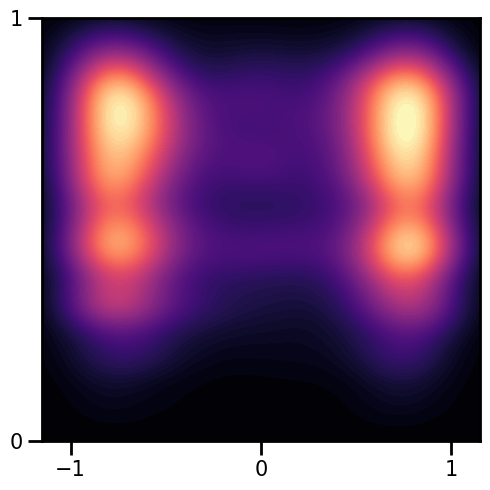

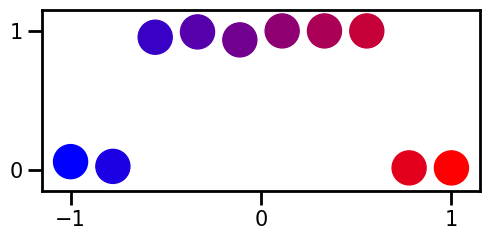

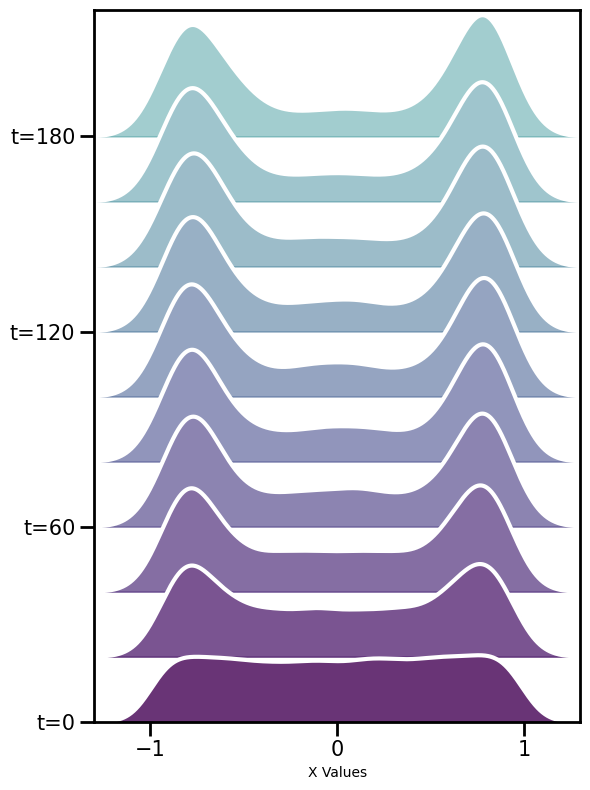

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Complete Action'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)

x_all=X[:,-1,:].flatten().cpu().numpy()
s_all=env.s.squeeze().repeat(rep).cpu().numpy()
if 1:
    fig, axes = plt.subplots(1, 1, figsize=(1*5, 5))  # Adjust the figure size as needed
    ax=axes
    sns.kdeplot(x=x_all, y=s_all, fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(0, 1)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig('xs200-complete_action_b10.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,2.5))
ax.scatter(env.ym.cpu(),c_mean,600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('xc200-complete_action_10.svg')
plt.show()



# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Define a colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Variables to control the vertical placement and scaling of KDEs
vertical_shift = 0.18 # Controls the vertical spacing between plots
scale_factor = 0.35   # Controls the height of each KDE plot
yp=0
# Plot KDE for t = 0, 10, ..., 200 with different colors and vertical shifts
for idx, t in enumerate(range(0, 200, 20)):
    data = X[:, t, :].flatten()
    kde = stats.gaussian_kde(data)
    x = np.linspace(-1.3, 1.3, 1000)
    y = kde(x) * scale_factor + idx * vertical_shift  # Scale and shift the KDE plot
    ax.fill_between(x, np.maximum(idx * vertical_shift,yp), y, color=colors[idx], alpha=8/(idx+10))
    ax.plot(x, y, color='white', linewidth=3)  # Add line for better visual separation
    yp=y

# Customize the plot
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([0, idx * vertical_shift + scale_factor])
ax.set_yticks([i * vertical_shift for i in range(10)])  # Set y-ticks to match the shifted plots
ax.set_yticklabels([f't={t}' for t in range(0, 200, 20)])  # Label y-ticks with values of t
ax.set_xlabel('X Values')
ax.grid(False)  # Turn off the grid for a cleaner look


ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 3*vertical_shift,6*vertical_shift,9*vertical_shift])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig('xt200-complete_action_b10.svg')
plt.show()